# Diabetes Dataset
This dataset was used in https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf
by Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani, in Annals of Statistics (2004).

As part of the activities in _MCZA015 - 13_ in Universidade Federal do ABC(UFABC) in 2019.

Some general ideas to approach the problem:

   - linear regression
   - 30% teste - NO DATA LEAKAGE PLS
   - START WITH ONE PREDICTOR PER MODEL
   - y relation to prediction is linear? necessary to add polynomial features?
   - try to add more atributes to model
   - use CV to compare different models
   - Try fitting model without and with RIDGE
   - check for corr between atributes to look for colinearity
   - do models suffer degradation for test?
   - is test and train cv ordering of models similar?



A dataset that at first glance is clean and presents no null values.
Atributes such as 'age', 'bmi', 'map' seem adequate.
'Sex' shows by the mean that there are more of sex '1'.

'y' represents how critical is each patient's case. lower: better, higher: worse.



In [42]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
df = pd.read_csv("diabetes.csv")
print(df.columns)

In [83]:
df.head()
df.describe()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,545.984142,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,1526.681506,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.290500,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.695900,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,5.141700,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6107.000000,124.000000,346.000000


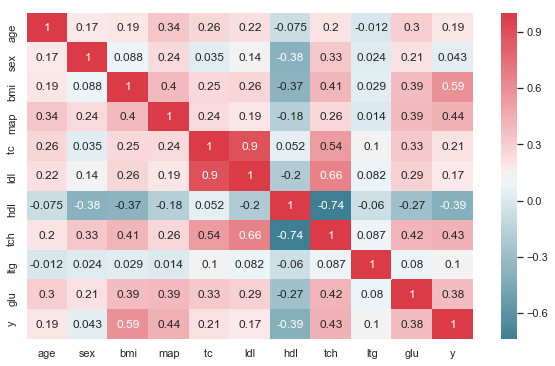

In [82]:
plt.figure(figsize=(10,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),annot=True, fmt='.2g',cmap=cmap)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DC3362A20>,
      dtype=object)

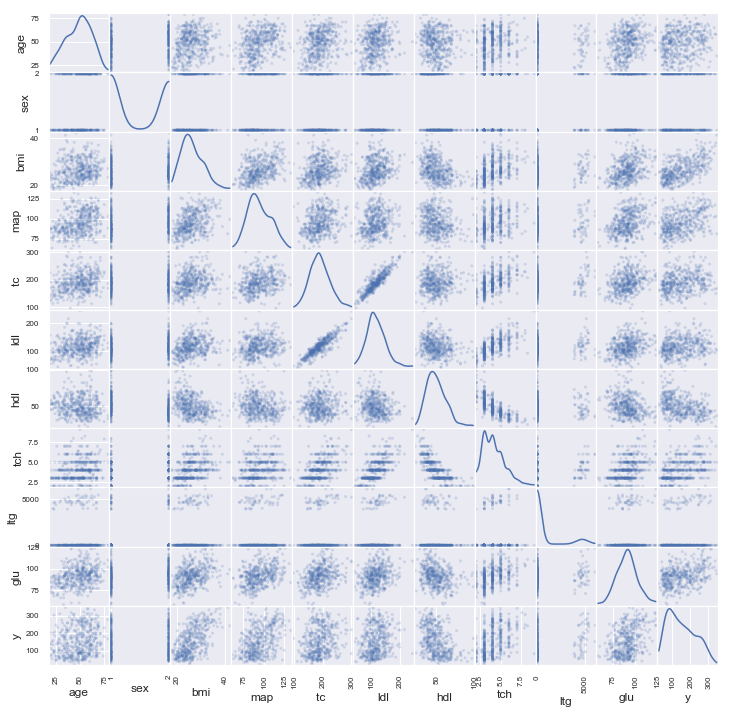

In [12]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha = 0.2, figsize = (12, 12), diagonal = 'kde')

_Podemos remover a ldl pois apresenta baixa correlação com y, ao mesmo tempo que apresenta alta colinearidade com tc(0.87) e tch(0.65)_

In [37]:
a = df[df['ltg']<3000]['ltg']
b = df[df['ltg']<3000]['y']
c = df[df['ltg']>3000]['ltg']
d = df[df['ltg']>3000]['y']

print('For ltg < 3000 the corr with y is: {:.3f}.\nFor ltg > 3000 the corr with y is: {:.3f}.'.format(a.corr(b),c.corr(d)))

For ltg < 3000 the corr with y is: 0.573.
For ltg > 3000 the corr with y is: 0.472.


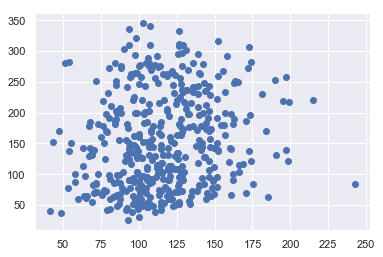

In [84]:
plt.scatter(df['ldl'],df['y'])

In [31]:
print('Kurtosis: {:.3f}. Skewness : {:.3f}.'.format(df['ltg'].kurtosis(),df['ltg'].skew()))

Kurtosis: 4.443. Skewness : 2.509.


_It seems that there is a stronger correlation between lower values of 'ltg' and 'y', however it is not a lot higher than the values above the 3000 bound. While its correlaton as a whole to the outcome is low(0.102), if we split, both ends have considerably __stronger correlations (0.573 for lower values and 0.472 for higher values)__ to the outcome variable. But I am not sure if this process wouldn't introduce bias in our data._

_In the above plot it is clear that there are high and low values of 'ltg' for any value of 'y'. Checking for __skewness and kurtosis__ it is clear that using the attribute as it is may be problematic. We cannot use the variable as it is._

__How should we treate this variabe? Split it in two columns(value is above 3000? = 1 else =0) or transform it?__


_Sex is extremely low correlated to the outcome while is correlated to hdl negatively(-0.379) and tch positively(0.332). So leaving it aside may improve the model._

In [ ]:
def poly_reg(DATA,degree,columns):
    X_train,X_test,y_train,y_test = train_test_split(
        DATA[columns],DATA['y'],test_size=0.3,shuffle=False)

    grau = degree
    poli = PolynomialFeatures(grau, include_bias=False)
    x_poli = poli.fit_transform(X_train)

    poli_model = LinearRegression(fit_intercept=True)
    poli_model.fit(x_poli, y_train)

    #ele não consegue fittar no modelo pois só tem '1 dimensão', não 10 como o dataset original.
    #xbase = np.linspace(0, 10, 1000)
    #xfit = poli.fit_transform(xbase[:,np.newaxis])
    #yfit = poli_model.predict(xfit)
    #plt.plot(xbase, yfit);
    
    #print("Coeficientes:      ", poli_model.coef_)
    print("Ordenada na origem:", poli_model.intercept_)
    print("Erro quadrático médio:", mean_squared_error(y_train, poli_model.predict(x_poli)))
    print("R^2:", r2_score(y_train, poli_model.predict(x_poli)))
    
    #plt.scatter(X_train.iloc[:,-2], y_train)
    
    eval_score = cross_val_score(poli_model,x_poli,y_train,scoring='r2',cv=10)
    
    residuos = y_train - poli_model.predict(x_poli)
    plt.scatter(y_train, residuos)


    return np.mean(eval_score)

In [ ]:
def ridge_reg(data,deg,cols):
    X_train,X_test,y_train,y_test = train_test_split(
        data[cols],data['y'],test_size=0.3,shuffle=False)

    grau = deg
    poli = PolynomialFeatures(grau, include_bias=False)
    x_poli = poli.fit_transform(X_train)

    poli_md = Ridge(fit_intercept=True, alpha=4)
    poli_md.fit(x_poli, y_train)

    #xbase = np.linspace(0, 10, 1000)
    #xfit = poli.fit_transform(xbase[:, np.newaxis])
    #yfit = poli_model.predict(xfit)

    #print("Coeficientes:      ", poli_md.coef_)
    print("Ordenada na origem:", poli_md.intercept_)
    print("Erro quadrático médio:", mean_squared_error(y_train, poli_md.predict(x_poli)))
    print("R^2:", r2_score(y_train, poli_md.predict(x_poli)))
    
    eval_score_r = cross_val_score(poli_md,x_poli,y_train,scoring='r2',cv=10)
    
    residuos_r = y_train - poli_md.predict(x_poli)
    plt.scatter(y_train, residuos_r)

    return np.mean(eval_score_r)

Ordenada na origem: 7764.064149933603
Erro quadrático médio: 2029.5217634554285
R^2: 0.6635670147468251
Ordenada na origem: 7764.064149933603
Erro quadrático médio: 2029.5217634554285
R^2: 0.6635670147468251


-0.9550902415957179

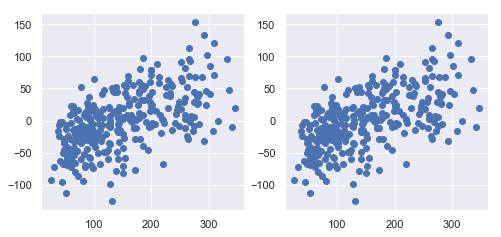

In [122]:
plt.figure(figsize=(8,8))
plt.subplot(221)
poly_reg(df,3,df.columns.difference(['ltg','sex','ldl','y']))

plt.subplot(222)
poly_reg(df,2,df.columns.difference(['ltg','sex','ldl','y']))

Ordenada na origem: 2094.9847168051692
Erro quadrático médio: 2079.3468088673394
R^2: 0.6553075375290178
Ordenada na origem: 2094.9847168051692
Erro quadrático médio: 2079.3468088673394
R^2: 0.6553075375290178


-0.4116160200762479

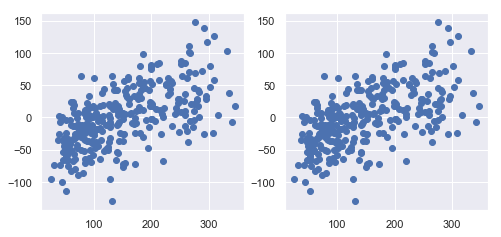

In [121]:
plt.figure(figsize=(8,8))
plt.subplot(221)
ridge_reg(df,3,df.columns.difference(['ltg','sex','ldl','y']))

plt.subplot(222)
ridge_reg(df,2,df.columns.difference(['ltg','sex','ldl','y']))

Testing different variables one by one:
col0 = linear
col1 = no change
col2 = linear
col3 = linear
col4 = linear
col5 = linear
col6 = 2 or 6
col7 = linear
col8 = 4
col9 = 2

__Para grau = 3:__
- Removendo __sex e ltg__ o cross val score(cvs) com r2 é -4 com poly e -2.7 com ridge bem melhor do que em outros cenários com ltg que varia demasiado.
- Removendo __ltg__ -10 poly e -5 ridge
> Conclusão: __ltg__ não parece informativa.

- __tc__ é muito fortemente correlacionado com ldl, e correlacionado consideravelmente com tch.
- Removendo __ltg e ldl__ em poly temos cvs de -2.89 e em ridge -1.53.
> Conclusão __ldl__ parece uma boa candidata a remoção.

- Removendo __ltg, sex e ldl__ o poly cvs é -0.95 e o ridge é -0.41

In [250]:
#working with lasso to penalize l1 norm?
from sklearn.linear_model import LassoCV,Lasso
from sklearn.model_selection import GridSearchCV

dfa = df.copy()
cols = df.columns.difference(['y'])
X_trn,X_tst,y_trn,y_tst = train_test_split(
        dfa[cols],dfa['y'],test_size=0.3,shuffle=False)

alphas = np.logspace(-2, 2,30)

lasso = Lasso( random_state=0).fit(X_trn, y_trn)
reg = LassoCV(cv=10, random_state=0)#.fit(X_trn, y_trn)
#reg.score(X_trn, y_trn)

clf = GridSearchCV(lasso, [{'alpha': alphas}], cv=10, refit=True,verbose=1)
clf.fit(X_trn, y_trn)


scores = clf.cv_results_['mean_test_score'].mean()

lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=0)
#scores
print(scores)
clf.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.389608207845257


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.5s finished
C:\Users\Bronze\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

In [240]:
dd = reg.fit(X_trn[X_trn.columns.difference(['ltg','ldl'])],y_trn).predict(
    X_trn[X_trn.columns.difference(['ltg','ldl'])])

In [259]:
cross_val_score(lasso,X_trn,y_trn,cv=10).mean()

0.40504961096205416